<a href="https://colab.research.google.com/github/rawanmahdi/retinopathy-explained/blob/main/retinopathy_expected_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import imutils
import os
from skimage import exposure
from imblearn.over_sampling import ADASYN
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Multiply, Reshape, Permute

import keras.backend as K
import numpy as np
import json
import shap

# import tensorflow.compat.v1.keras.backend as K
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()


In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')
model = tf.keras.models.load_model("/content/gdrive/My Drive/retinopathy-explained/accuracy_93")
model.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256     

In [ ]:
from skimage import io
image_size = 224
sample_size = 1000
def crop_image(image_file):
    #drive.mount('/content/gdrive')
    img = io.imread(image_file)
    #print(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy=img.copy()
    lower=np.array([10,10,10])
    higher=np.array([250,250,250])
    mask=cv2.inRange(img, lower, higher)
    contours, hierarchy = cv2.findContours(image= mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)

    cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0,
                              color=(0,255,0),thickness=3)
    c=sorted_contours[0]
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
    cropped_image=img_copy[y:y+h+1, x:x+w+1]
    hsv_img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
    h,s,v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit= 2, tileGridSize=(10,10))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    #image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = cv2.resize(image,(image_size,image_size))
    return image

### TESTING DATASET ###

In [ ]:
cataract_images = []
glaucoma_images = []
normal_images = []
retinopathy_images = []


for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/normal'):
  normal_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/normal/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/cataract'):
  cataract_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/cataract/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/glaucoma'):
  glaucoma_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/glaucoma/'+ filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/dataset/diabetic_retinopathy'):
  retinopathy_images.append('/content/gdrive/My Drive/retinopathy-explained/dataset/diabetic_retinopathy/'+ filename)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

labels = []
dataset = []

def create_dataset(image_category,label):
    #drive.mount('/content/gdrive')
    for img in tqdm(image_category[:1000]):
        image_path = img
        try:
            image = crop_image(image_path)
        except:
            continue

        dataset.append([np.array(image),np.array(label)])

    random.shuffle(dataset)
    return dataset

dataset = create_dataset(cataract_images,1)
dataset = create_dataset(normal_images,0)
dataset = create_dataset(glaucoma_images,2)
dataset = create_dataset(retinopathy_images,3)

100%|██████████| 1000/1000 [00:21<00:00, 46.55it/s]


In [ ]:
print(len(dataset))

4000


In [ ]:
X = np.array([item[0] for item in dataset])
Y = np.array([item[1] for item in dataset])
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
x_train,x_test,y_train,y_test  = train_test_split(x,y,test_size=0.9)

In [ ]:
subsample_size = 3
def create_subdataset(image_category):
  images = []
  for img in tqdm(image_category[:subsample_size]):
    image_path = img
    try:
      image = crop_image(image_path)
    except:
      continue
    images.append(np.array(image))
  return np.array(images)

cataract_X = create_subdataset(cataract_images)
normal_X = create_subdataset(normal_images)
glaucoma_X = create_subdataset(glaucoma_images)
retinopathy_X = create_subdataset(retinopathy_images)

100%|██████████| 3/3 [00:00<00:00, 50.02it/s]


In [ ]:
X,y = x_train, y_train
to_explain = np.array([normal_X[0,:], cataract_X[0,:], glaucoma_X[0,:], retinopathy_X[0,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])

(4, 224, 224, 3)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


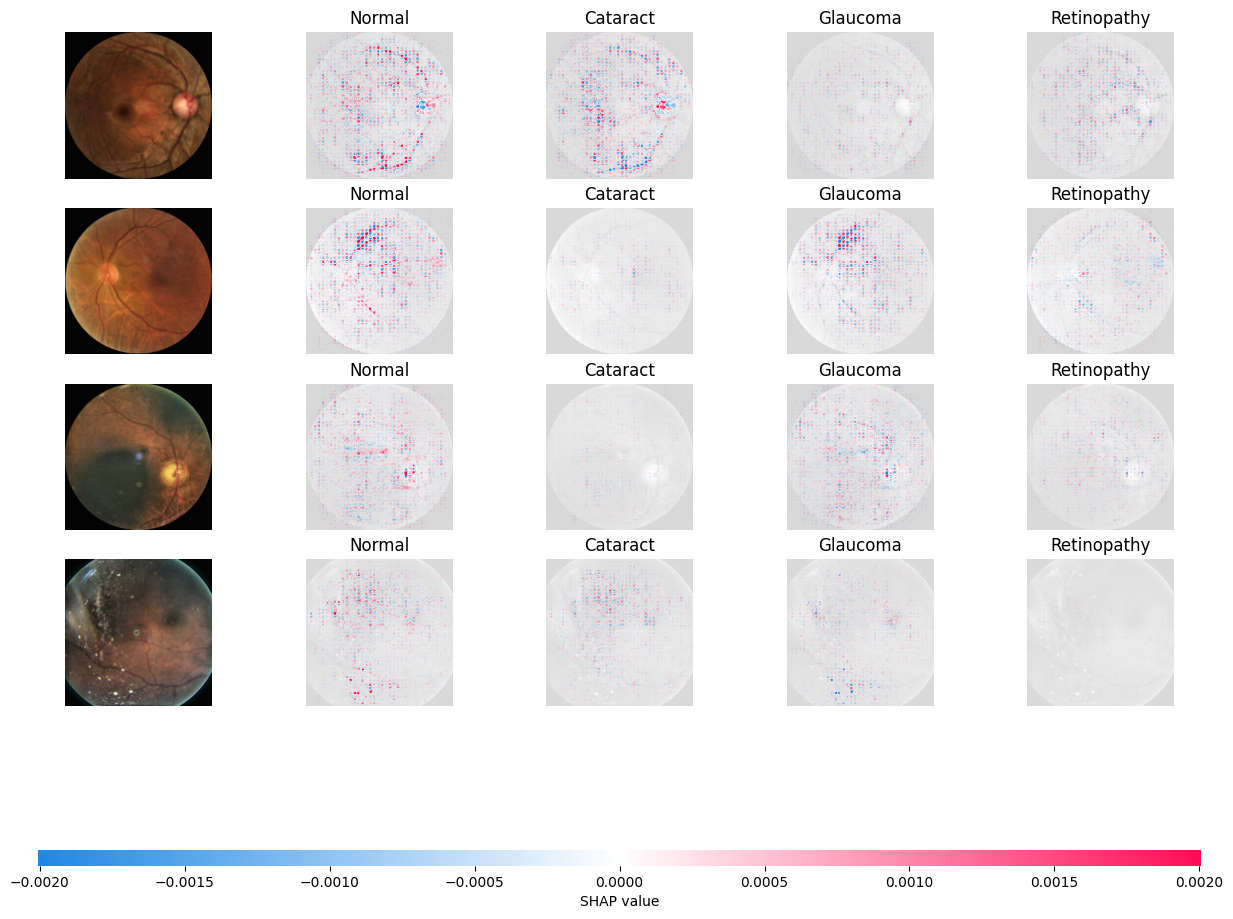

In [ ]:
e = shap.GradientExplainer(
    model,
    X,
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)


In [ ]:
X,y = x_train, y_train
to_explain = np.array([normal_X[1,:], cataract_X[1,:], glaucoma_X[1,:], retinopathy_X[1,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])

(4, 224, 224, 3)


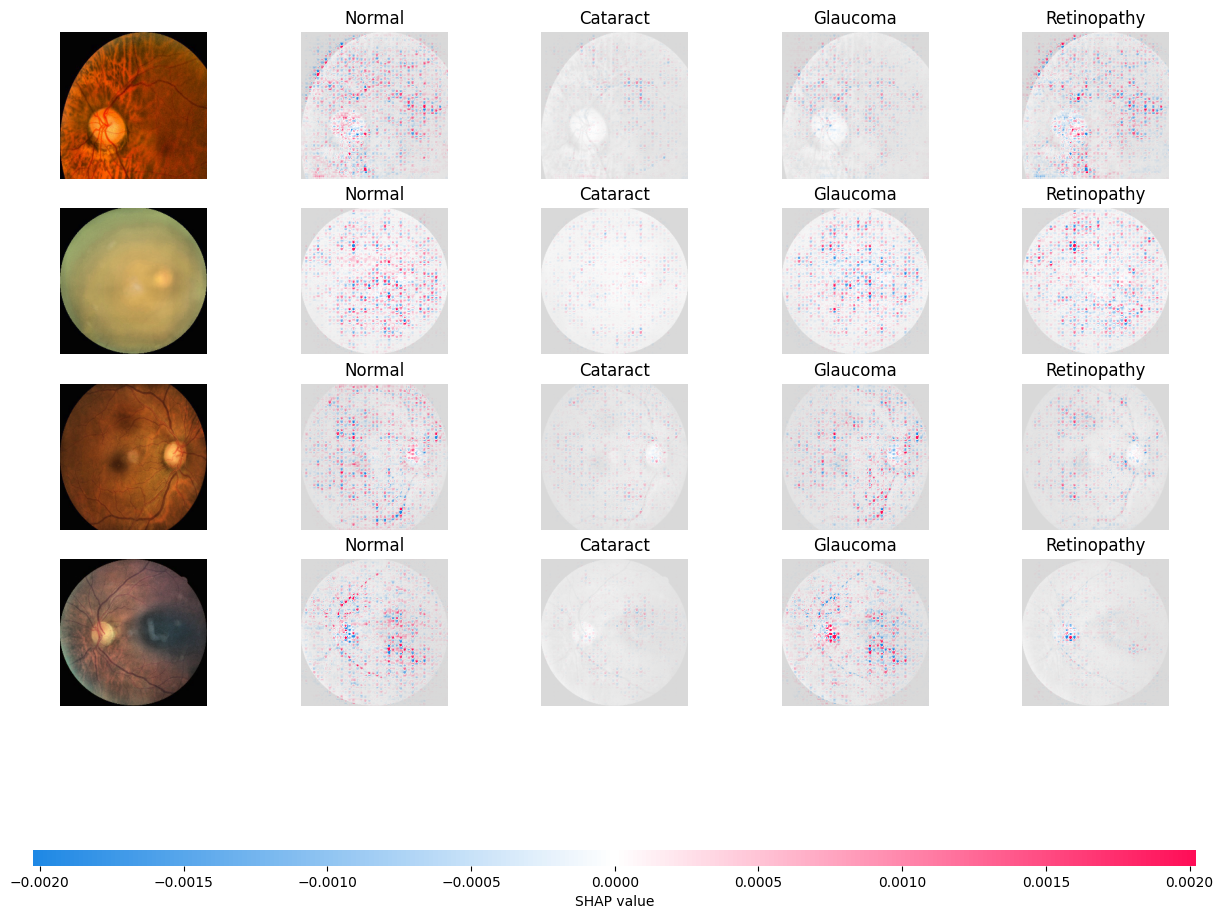

In [ ]:
e = shap.GradientExplainer(
    model,
    X,
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)


(4, 224, 224, 3)


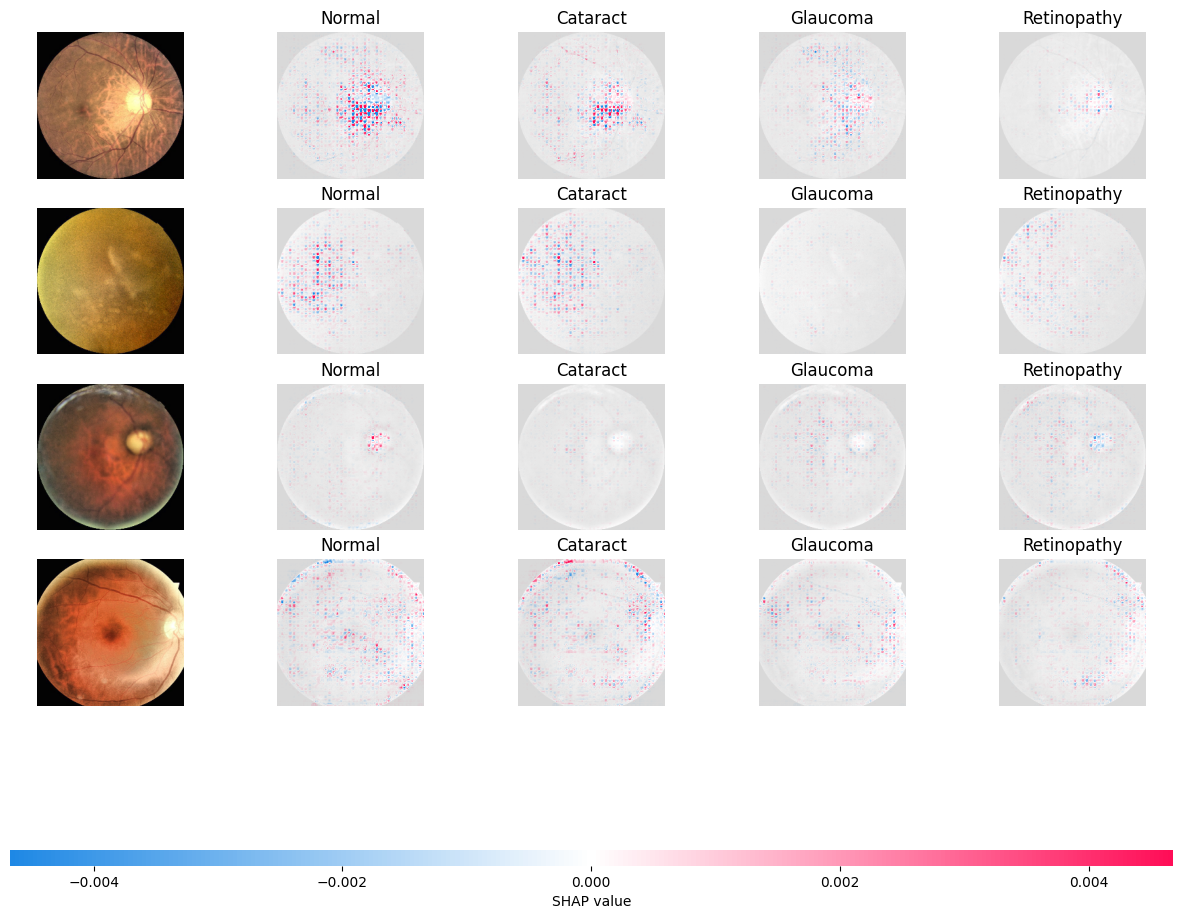

In [ ]:
X,y = x_train, y_train
to_explain = np.array([normal_X[2,:], cataract_X[2,:], glaucoma_X[2,:], retinopathy_X[2,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])
e = shap.GradientExplainer(
    model,
    X,
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)

In [ ]:
X,y = x_train, y_train

true_labels = y_train[0:6]
print((true_labels))

[2 0 2 2 2 3]


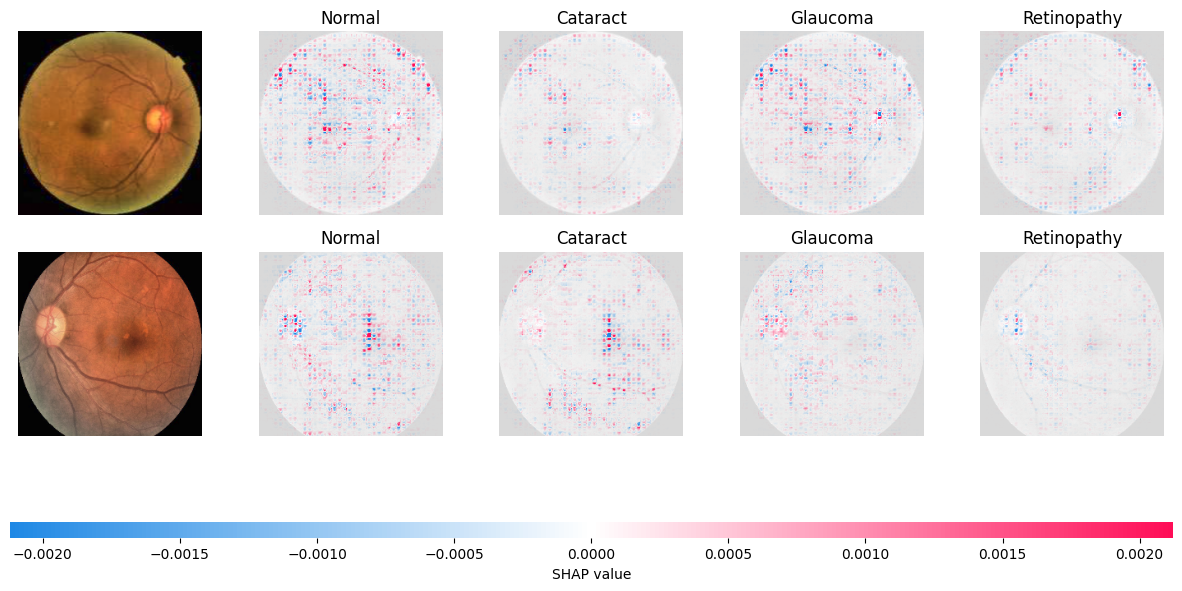

In [ ]:
e = shap.GradientExplainer(
    model,
    X,
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
labels = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])
shap.image_plot(shap_values, to_explain, labels)


### TRAINING DATASET ###

In [ ]:
ground_truth_df = pd.read_excel("/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/data.csv")
ground_truth_df.head(5)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occlusion  0  0  0  0  0  0  0  1  
4       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1

In [ ]:
# accessing all training and testing retinal fundus images
training_filenames = []
testing_filenames = []

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/Testing Images'):
  testing_filenames.append(filename)

for filename in os.listdir('/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/ODIR-5K/ODIR-5K/Training Images'):
  training_filenames.append(filename)


In [ ]:
# functions to narrow down dataframe

# diabetic retinopathy
def has_retinopathy(text):
    if "retinopathy" in text:
        return 1
    else:
        return 0

# glaucoma
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

# normal
def has_normal(text):
    if "normal" in text:
        return 1
    else:
        return 0

# cataract
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
ground_truth_df["left_glaucoma"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
ground_truth_df["right_glaucoma"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
left_glaucoma = ground_truth_df.loc[(ground_truth_df.G ==1) & (ground_truth_df.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = ground_truth_df.loc[(ground_truth_df.G ==1) & (ground_truth_df.right_glaucoma == 1)]["Right-Fundus"].values
glaucoma_images = np.concatenate((left_glaucoma,right_glaucoma),axis=0)


ground_truth_df["left_normal"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_normal(x))
ground_truth_df["right_normal"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_normal(x))
left_normal = ground_truth_df.loc[(ground_truth_df.C ==0) & (ground_truth_df.left_normal == 1)]["Left-Fundus"].values
right_normal = ground_truth_df.loc[(ground_truth_df.C ==0) & (ground_truth_df.right_normal == 1)]["Right-Fundus"].values
normal_images = np.concatenate((left_normal,right_normal),axis=0)


ground_truth_df["left_retinopathy"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
ground_truth_df["right_retinopathy"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
left_retinopathy = ground_truth_df.loc[(ground_truth_df.D ==1) & (ground_truth_df.left_retinopathy == 1)]["Left-Fundus"].values
right_retinopathy = ground_truth_df.loc[(ground_truth_df.D ==1) & (ground_truth_df.right_retinopathy == 1)]["Right-Fundus"].values
retinopathy_images = np.concatenate((left_retinopathy,right_retinopathy),axis=0)


ground_truth_df["left_cataract"] = ground_truth_df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
ground_truth_df["right_cataract"] = ground_truth_df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = ground_truth_df.loc[(ground_truth_df.C ==1) & (ground_truth_df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = ground_truth_df.loc[(ground_truth_df.C ==1) & (ground_truth_df.right_cataract == 1)]["Right-Fundus"].values
cataract_images = np.concatenate((left_cataract,right_cataract),axis=0)

# printing lengths of training sets for each class
print( len(normal_images), len(cataract_images), len(retinopathy_images), len(glaucoma_images))

3047 313 1820 326


In [ ]:
def pre_processing_image(image_file):
    """
    This function takes an image file path as input and returns the preprocessed image after performing the following
    operations: cropping, CLAHE, denoising, optic disc and macula detection, and normalization.
    """
    # Reading the image and converting it to RGB format
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img.copy()

    # Thresholding to create a binary mask
    lower = np.array([10, 10, 10])
    higher = np.array([250, 250, 250])
    mask = cv2.inRange(img, lower, higher)

    # Finding contours and selecting the largest one
    contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    c = sorted_contours[0]

    # Finding the bounding box around the selected contour
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img=img, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=3)

    # Cropping the image
    cropped_image = img_copy[y:y + h + 1, x:x + w + 1]

    # Converting the cropped image to HSV format
    hsv_img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
    h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]

    # Applying CLAHE to the V channel
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(10, 10))
    v = clahe.apply(v)

    # Combining the H, S, and V channels to form the preprocessed image
    hsv_img = np.dstack((h, s, v))
    image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

#     # Applying denoising to remove noise and artifacts
#     image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # performing optic disc and macula detection using Hough transform-based approaches
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    disc_radius = int(h / 5)
    disc_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (disc_radius, disc_radius))
    disc_top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, disc_kernel)
    disc_edges = cv2.Canny(disc_top_hat, 10, 50)
    disc_circles = cv2.HoughCircles(disc_edges, cv2.HOUGH_GRADIENT, dp=1, minDist=int(disc_radius * 1.5),
                                    param1=50, param2=15, minRadius=int(disc_radius * 0.75),
                                    maxRadius=int(disc_radius * 1.25))
    disc_center = (disc_circles[0][0][0], disc_circles[0][0][1])
    disc_radius = int(disc_circles[0][0][2] * 0.9)


    # Performing macula detection
    macula_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    macula_top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, macula_kernel)
    macula_edges = cv2.Canny(macula_top_hat, 30, 100)
    _, macula_contours, hierarchy = cv2.findContours(image=macula_edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    macula_contours = sorted(macula_contours, key=cv2.contourArea, reverse=True)[:1]
    macula_mask = np.zeros_like(gray)
    cv2.drawContours(macula_mask, macula_contours, -1, 255, thickness=-1)
    macula_masked_image = np.zeros_like(gray)
    macula_masked_image[macula_mask == 255] = gray[macula_mask == 255]
    macula_center = cv2.minEnclosingCircle(macula_contours[0])[0]

    # Creating a circular mask of the same size as the preprocessed image
    mask = np.zeros_like(image)
    rows, cols, _ = mask.shape
    circle_img = cv2.circle(mask, center=disc_center, radius=disc_radius, color=(1, 1, 1), thickness=-1)

    # Applying the mask to the preprocessed image to obtain the segmented optic disc region
    disc_region = np.multiply(image, circle_img)

    # Normalizing the segmented optic disc region
    norm_disc_region = exposure.equalize_adapthist(disc_region, clip_limit=0.03)

        # Normalizing the image
    image = cv2.normalize(norm_disc_region, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return image

from skimage import io

def crop_image(image_file):
    #drive.mount('/content/gdrive')
    img = io.imread(image_file)
    #print(img)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy=img.copy()
    lower=np.array([10,10,10])
    higher=np.array([250,250,250])
    mask=cv2.inRange(img, lower, higher)
    contours, hierarchy = cv2.findContours(image= mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)

    cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0,
                              color=(0,255,0),thickness=3)
    c=sorted_contours[0]
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
    cropped_image=img_copy[y:y+h+1, x:x+w+1]
    hsv_img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
    h,s,v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit= 2, tileGridSize=(10,10))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    #image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = cv2.resize(image,(image_size,image_size))
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

dataset_dir = "/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/preprocessed_images"
labels = []
dataset = []

def create_dataset(image_category,label):
    #drive.mount('/content/gdrive')
    for img in tqdm(image_category[:sample_size]):
        image_path = dataset_dir + '/' + img
        try:
            image = crop_image(image_path)
        except:
          continue
        dataset.append([np.array(image),np.array(label)])

    random.shuffle(dataset)
    return dataset

In [ ]:
image_size = 224
sample_size = 1000

In [ ]:
dataset = create_dataset(cataract_images,1)
dataset = create_dataset(normal_images,0)
dataset = create_dataset(glaucoma_images,2)
dataset = create_dataset(retinopathy_images,3)

100%|██████████| 1000/1000 [01:43<00:00,  9.71it/s]


In [ ]:
X = np.array([item[0] for item in dataset])
Y = np.array([item[1] for item in dataset])

# # Flatten 4D input images into 2D arrays
# X_flat = np.reshape(X, (X.shape[0], -1))
# ratio = {0: sample_size, 1: sample_size, 2: sample_size}
# # Create an instance of the ADASYN oversampler
# adasyn = ADASYN(sampling_strategy=ratio)

# X_resampled_flat, y_resampled = adasyn.fit_resample(X_flat, Y)

# # Reshape the oversampled data back to the original shape
# X_resampled = np.reshape(X_resampled_flat, (X_resampled_flat.shape[0], *X.shape[1:]))

# for i in range(len(X_resampled)):
#     dataset.append([X_resampled[i], y_resampled[i]])
# print(len(dataset))

In [ ]:
# splitting the data into train and test split
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
X,y = x_train, y_train
e = shap.GradientExplainer(
    model,
    X,
    local_smoothing=0 # std dev of smoothing noise
)

In [ ]:
subsample_size = 6
from tensorflow.keras.preprocessing.image import load_img,img_to_array

dataset_dir = "/content/gdrive/My Drive/retinopathy-explained/Ocular_Disease_Recognition/preprocessed_images"

def create_subdataset(image_category):
  images = []
  for img in tqdm(image_category[:subsample_size]):
    image_path = dataset_dir + '/' + img
    try:
      image = crop_image(image_path)
    except:
       continue
    images.append(np.array(image))
  return np.array(images)

cataract_X = create_subdataset(cataract_images)
normal_X = create_subdataset(normal_images)
glaucoma_X = create_subdataset(glaucoma_images)
retinopathy_X = create_subdataset(retinopathy_images)

100%|██████████| 6/6 [00:00<00:00, 36.10it/s]


In [ ]:
print(cataract_X.shape)
print(normal_X.shape)
print(glaucoma_X.shape)
print(retinopathy_X.shape)

(5, 224, 224, 3)
(3, 224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)


(4, 224, 224, 3)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


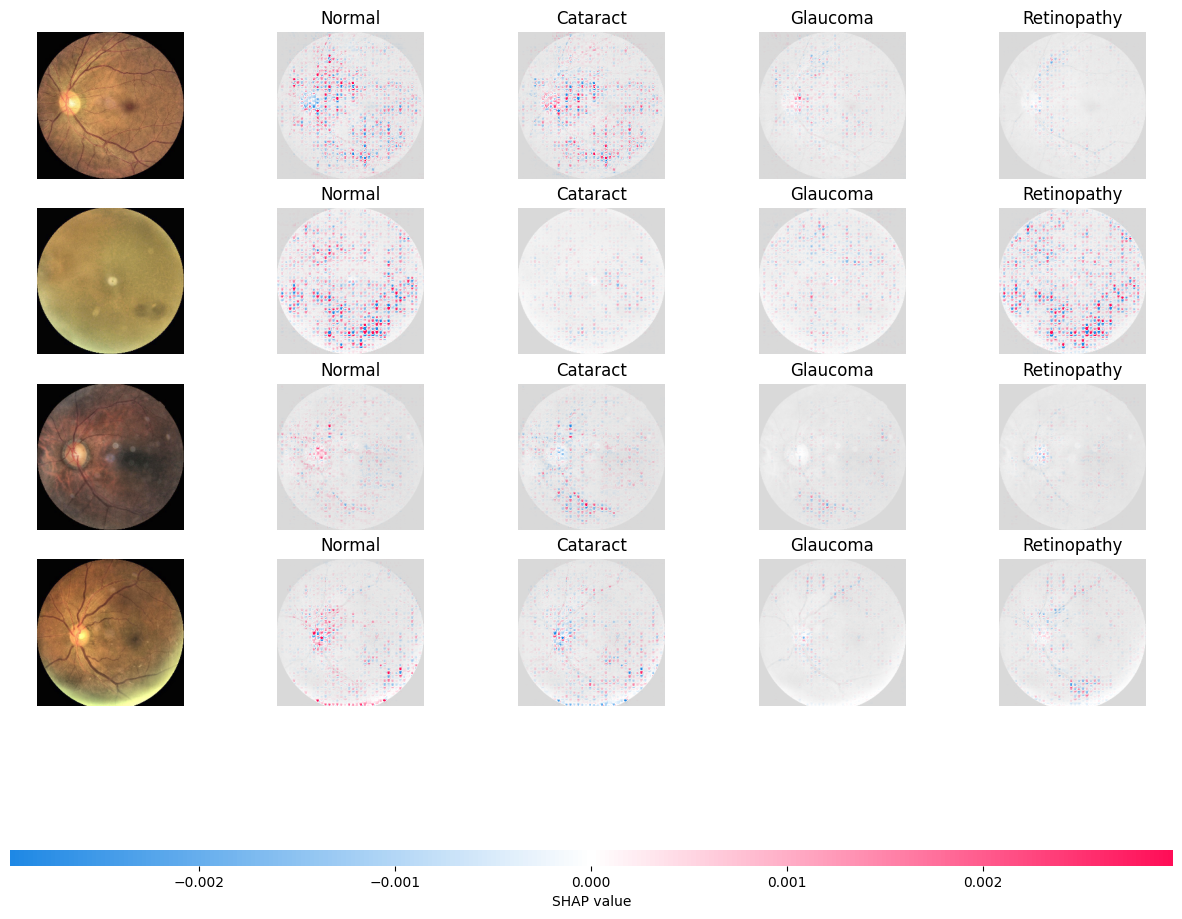

In [ ]:
to_explain = np.array([normal_X[0,], cataract_X[0,:], glaucoma_X[0,:], retinopathy_X[0,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)

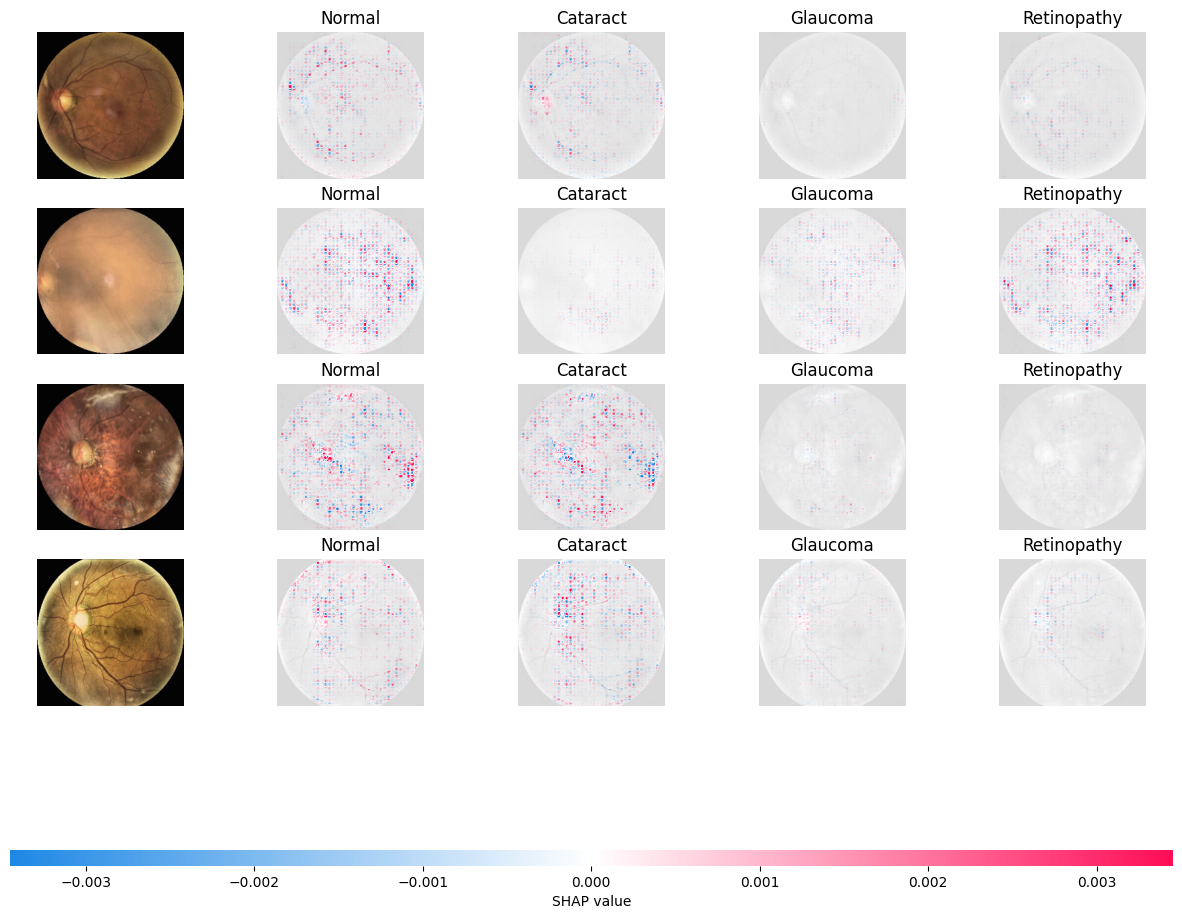

In [ ]:
to_explain = np.array([normal_X[1,], cataract_X[1,:], glaucoma_X[1,:], retinopathy_X[1,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)

(4, 224, 224, 3)


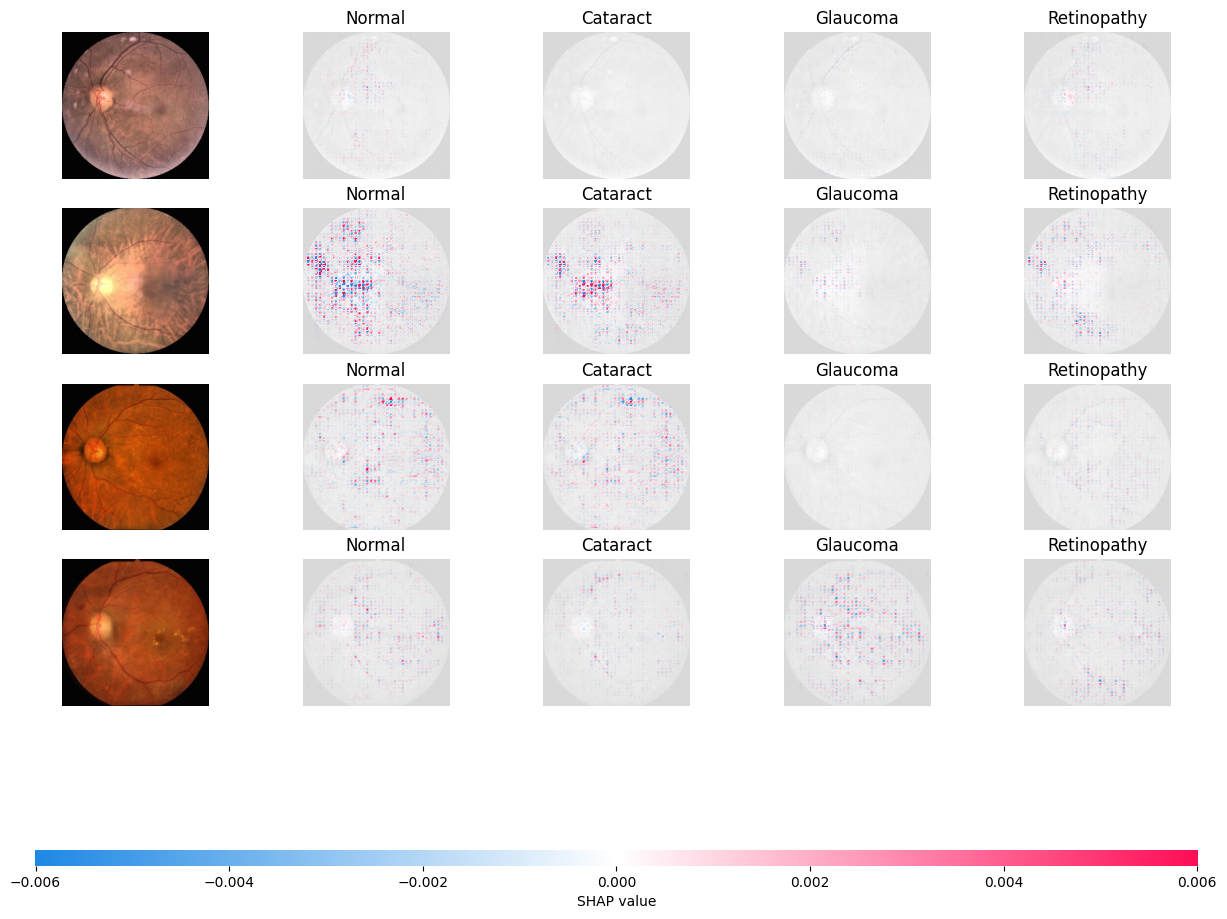

In [ ]:
to_explain = np.array([normal_X[2,], cataract_X[2,:], glaucoma_X[2,:], retinopathy_X[2,:]])
print(to_explain.shape)
class_names = np.array([['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"],
                  ['Normal', 'Cataract', "Glaucoma", "Retinopathy"]])
shap_values,indexes = e.shap_values(to_explain, ranked_outputs=4)
# plot the explanations
shap.image_plot(shap_values, to_explain, class_names)